## Bibiliothèque

In [2]:
import numpy as np
import tensorflow as tf;
import matplotlib.pyplot as plt
from resnet import resnet_v2
import time
%matplotlib inline
seed = tf.random.set_seed(42)


In [3]:
def plot_hist(figname):
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.plot(accuracy, label = "train accuracy")
    plt.plot(val_accuracy, label = "validation accuracy")
    plt.title("Accuracy")
    plt.grid()
    plt.legend()

    plt.subplot(122)
    plt.plot(l, label = "train loss")
    plt.plot(val_l, label = "validation loss")
    plt.title("Loss")
    plt.grid()
    plt.legend()

    plt.savefig(figname)
    plt.show()
    
def inference_time():
    scratch = []
    pruned = []
    for i in range(10):
        t1 = time.time()
        pred1 = scratch_model(x_test)
        t2 = time.time()
        scratch.append(t2-t1)

        # Pruned model
        t3 = time.time()
        pred2 = P.model(x_test)
        t4 = time.time()
        pruned.append(t4-t3)

    # display
    print("Scratch inference time : ", np.mean(scratch), " s")
    print("Pruned inference time : ", np.mean(pruned), " s")
    return np.mean(pruned)


def count_parameters(model):
    somme = 0
    for l in model.trainable_variables:
        somme += np.count_nonzero(l)
    return somme



def scratch_hist():   
    loss = dico["scratch_hist"][0].history["loss"]
    val_loss = dico["scratch_hist"][0].history["val_loss"]
    accuracy = dico["scratch_hist"][0].history["sparse_categorical_accuracy"]
    val_accuracy =  dico["scratch_hist"][0].history["val_sparse_categorical_accuracy"]

    for i in range(len( dico["scratch_hist"])):
        if i !=0:
            loss = np.append(loss, dico["scratch_hist"][i].history["loss"])
            val_loss = np.append(val_loss, dico["scratch_hist"][i].history["val_loss"])
            accuracy = np.append(accuracy, dico["scratch_hist"][i].history["sparse_categorical_accuracy"])
            val_accuracy =  np.append(val_accuracy, dico["scratch_hist"][i].history["val_sparse_categorical_accuracy"])

    dico["scratch_hist"] = (accuracy, val_accuracy, loss, val_loss)

## Loading Mnist Dataset

In [12]:
def padding_mnist(x_train, x_test, pad=1):
    
    x = np.zeros((x_train.shape[0],x_train.shape[1]+2*pad, x_train.shape[2]+2*pad ))
    xt = np.zeros((x_test.shape[0],x_test.shape[1]+2*pad, x_test.shape[2]+2*pad ))
    
    for i in range(x_train.shape[0]):
        x[i] = np.pad(x_train[i], pad)
        if i < x_test.shape[0]:
            xt[i] = np.pad(x_test[i], pad)
            
    return (x, xt)
            
        

print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")


#padding
x_train, x_test = padding_mnist(x_train, x_test, pad=2)

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

x_train = np.reshape(x_train, (-1,32,32,1))
x_test = np.reshape(x_test, (-1,32,32,1))

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")


================ Data Loading ================
x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)

x_train shape: (60000, 32, 32)
x_test shape: (10000, 32, 32)
y_train shape: (60000,)
y_test shape: (10000,)

x_train shape: (60000, 32, 32, 1)
x_test shape: (10000, 32, 32, 1)
y_train shape: (60000,)
y_test shape: (10000,)



## Building Lenet5 model 

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)),
    tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding="valid"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=120, activation='relu'),
    tf.keras.layers.Dense(units=84, activation='relu'),
    tf.keras.layers.Dense(units=10, activation="softmax")

]);

model.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

2022-07-20 11:11:56.148785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-20 11:11:56.148809: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-20 11:11:56.148823: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (karim-Swift-SF514-53T): /proc/driver/nvidia/version does not exist
2022-07-20 11:11:56.149385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Scratch Training

In [14]:
# disctionnaire pour enregistrer les infos pertinentes
dico = {}
scratch_model = tf.keras.models.clone_model(model)

In [15]:
BATCH_SIZE = 32
EPOCHS = 100
lr = 1

In [16]:
dico["scratch_hist"] = []
for epoch in [75, 15, 10 ]:
    lr /= 10
    scratch_model.compile(
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
            loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            )

        # Train and evaluate on data.
    hist = scratch_model.fit(x_train, y_train, 
          batch_size = BATCH_SIZE,
          epochs= epoch,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          )

    scratch_model.evaluate(x_test, y_test)
    dico["scratch_hist"].append(hist)
scratch_hist()

Epoch 1/75


2022-07-20 11:12:04.055347: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


1875/1875 [==============================] - 14s 7ms/step - loss: 0.2252 - sparse_categorical_accuracy: 0.9280 - val_loss: 0.0623 - val_sparse_categorical_accuracy: 0.9806
Epoch 2/75
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0701 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.0625 - val_sparse_categorical_accuracy: 0.9802
Epoch 3/75
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0491 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.0329 - val_sparse_categorical_accuracy: 0.9888
Epoch 4/75
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0385 - sparse_categorical_accuracy: 0.9876 - val_loss: 0.0412 - val_sparse_categorical_accuracy: 0.9873
Epoch 5/75
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0311 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.0395 - val_sparse_categorical_accuracy: 0.9877
Epoch 6/75
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0259 - sparse_cat

1875/1875 [==============================] - 12s 6ms/step - loss: 2.3139e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0534 - val_sparse_categorical_accuracy: 0.9915
Epoch 46/75
1875/1875 [==============================] - 12s 6ms/step - loss: 2.1489e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0537 - val_sparse_categorical_accuracy: 0.9916
Epoch 47/75
1875/1875 [==============================] - 12s 6ms/step - loss: 2.0337e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0540 - val_sparse_categorical_accuracy: 0.9916
Epoch 48/75
1875/1875 [==============================] - 12s 6ms/step - loss: 1.8943e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0543 - val_sparse_categorical_accuracy: 0.9916
Epoch 49/75
1875/1875 [==============================] - 12s 6ms/step - loss: 1.8388e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0544 - val_sparse_categorical_accuracy: 0.9915
Epoch 50/75
1875/1875 [==============================] - 12s 6ms/step - 

2022-07-20 11:27:36.222875: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


1875/1875 [==============================] - 13s 7ms/step - loss: 7.3838e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0592 - val_sparse_categorical_accuracy: 0.9914
Epoch 2/15
1875/1875 [==============================] - 12s 7ms/step - loss: 7.3646e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0592 - val_sparse_categorical_accuracy: 0.9914
Epoch 3/15
1875/1875 [==============================] - 12s 7ms/step - loss: 7.3454e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0593 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/15
1875/1875 [==============================] - 12s 7ms/step - loss: 7.3279e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0593 - val_sparse_categorical_accuracy: 0.9914
Epoch 5/15
1875/1875 [==============================] - 13s 7ms/step - loss: 7.3111e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0593 - val_sparse_categorical_accuracy: 0.9914
Epoch 6/15
1875/1875 [==============================] - 12s 7ms/step - loss:

2022-07-20 11:30:44.520403: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


1875/1875 [==============================] - 13s 7ms/step - loss: 7.1262e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0594 - val_sparse_categorical_accuracy: 0.9915
Epoch 2/10
1875/1875 [==============================] - 12s 7ms/step - loss: 7.1247e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0594 - val_sparse_categorical_accuracy: 0.9915
Epoch 3/10
1875/1875 [==============================] - 12s 7ms/step - loss: 7.1232e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0594 - val_sparse_categorical_accuracy: 0.9915
Epoch 4/10
1875/1875 [==============================] - 12s 7ms/step - loss: 7.1218e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0594 - val_sparse_categorical_accuracy: 0.9916
Epoch 5/10
1875/1875 [==============================] - 12s 7ms/step - loss: 7.1204e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0594 - val_sparse_categorical_accuracy: 0.9916
Epoch 6/10
1875/1875 [==============================] - 12s 7ms/step - loss:

## Pruning class

In [17]:
class Pruning:
    def __init__(self, model, pruning_factor = 0.5):
        
        # attributs liés au model
        self.model = model
        self.pruning_factor = pruning_factor
    
    # Tensorflow utils setting
    def compile(self,optimizer, loss_fn, metric):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.acc_metric = metric
    
    # Pruning Function
    def pruning(self, P_factor = 0.5):
        if P_factor >=1 or P_factor <= 0:
            raise ValueError ("Pruning factor value Error : Pruning factor value should be ]0 ;1[")
        for layer in self.model.layers:
            if "conv" in layer.name:
                
                # Récuper les kernels
                w = layer.get_weights()[0]
                b = layer.get_weights()[1]
                
                # Calcul du filtre contenant la median
                tab = []
                for i in range(w.shape[-1]):
                    somme = 0
                    for j in range(w.shape[-1]):
                        if i !=j:
                            somme += np.linalg.norm(w[:,:,:,i] - w[:,:,:,j])
                    tab.append(somme)
                    
                # calcul du nombre de filtrer a annuler selon le facteur de pruning
                nb_pruned_filters = int(w.shape[-1]*P_factor)
                
                for i in range(nb_pruned_filters):
                    # récupérer l'indice du minimum
                    ind_min = np.argmin(tab)
                    
                    #anuuler le filtre qui minimise la formule précedente
                    w[:, :, :, ind_min] = np.zeros(w[:, :, :, ind_min].shape)
                    
                    # astuce pour déplacer le minimum lorsque il faut annuler plusieurs filtres
                    tab[ind_min] = 1e10
                
                layer.set_weights([w, b])


                
                
    #Training algorithm
    def train(self,x_train, y_train, val_data, val_labels, epochs = 100, batch_size= 32):
        self.epochs = epochs
        self.batch_size = batch_size
        
        # training history storage
        accur = []
        L = []
        
        # validation history storage
        v_accur = []
        v_loss = []

        if x_train.shape[0] % batch_size == 0:
            nb_train_steps = x_train.shape[0] // batch_size
        else:
            nb_train_steps = (x_train.shape[0] // batch_size) + 1
        # Training Loop
        for epoch in range(epochs):
            print(f"Epoch ({epoch +1 }/{epochs})")
            for i in range(nb_train_steps):
                # Batching data
                x = x_train[i*batch_size:(i+1)*batch_size]
                y = y_train[i*batch_size:(i+1)*batch_size]
                
                x = tf.constant(x)
                y = tf.constant(y)
                
                with tf.GradientTape() as tape:
                    # Forward pass
                    predictions = self.model(x, training = True)
                    # calcul de la loss
                    loss = self.loss_fn(y, predictions)
                    
                # Calcul du gradient
                grads = tape.gradient(loss, self.model.trainable_weights)
                
                # Decente de gradient
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
                
                #Pruning step
                self.pruning(P_factor = self.pruning_factor)
                
                # Update training metric.
                self.acc_metric.update_state(y, predictions)
                train_acc = self.acc_metric.result()
                
                print("Accuracy: {:.4f} ; loss: {:.4f}".format(float(train_acc),  loss), end='\r')
            print("\nValidation Step :")
            
            # Validation step
            val_accur, val_loss = self.test(val_data, val_labels)
                
            accur.append(float(train_acc))
            L.append(loss)
            
            v_accur.append(val_accur)
            v_loss.append(val_loss)
            print("")
        return (accur, L, v_accur, v_loss)  

    
    # Test Step 
    def test(self,data, labels):
        accur = []
        l = []
        if data.shape[0] % self.batch_size == 0:
            nb_test_steps = data.shape[0] // self.batch_size
        else:
            nb_test_steps = (data.shape[0] // self.batch_size) + 1
            
        for i in range(nb_test_steps):
            # Batching data
            x = data[i*self.batch_size:(i+1)*self.batch_size]
            y = labels[i*self.batch_size:(i+1)*self.batch_size]
            
            x = tf.constant(x)
            y = tf.constant(y)
            
            # Forward pass
            predictions = self.model(x)

            # calcul de la loss
            loss = self.loss_fn(y, predictions)
            # calcul de l'accuracy
            self.acc_metric.update_state(y, predictions)
            test_acc = self.acc_metric.result()
            print("Accuracy: {:.4f} ; loss: {:.4f}".format(float(test_acc),  loss), end='\r')
                
            accur.append(float(test_acc))
            l.append(float(loss))
        print("")        
        print("Accuracy Moy : {:.4f} ; loss Moy: {:.4f}" .format(np.mean(accur), np.mean(l) ))
        
        return (np.mean(accur), np.mean(l))

## Training Network

In [18]:
for p in [0.5, 0.6, 0.7, 0.8, 0.9]:
    accuracy = np.array([])
    val_accuracy = np.array([])

    l = np.array([])
    val_l = np.array([])


    P = Pruning(tf.keras.models.clone_model(model), 
                pruning_factor =p)
    lr = 1
    for epoch in [75,15,10]:
        # Paramètre d'entrainement
        lr /= 10
        P.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
                 loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metric = tf.keras.metrics.SparseCategoricalAccuracy(),
        )

        # Entrainement         
        accur, loss, val_accur, val_loss = P.train(x_train, y_train, 
                                                   x_test, y_test, 
                                                   epochs = epoch, 
                                                   batch_size= 32 )  


        # plot hist
        accuracy = np.append(accuracy, accur)
        val_accuracy = np.append(val_accuracy, val_accur)
        l = np.append(l, loss)
        val_l = np.append(val_l,val_loss)
    
    # Afficher les courbes d'entrainement
    #plot_hist(f"Lenet5_P_factor_{p}.png")
    
    # inference time
    pruned_inf_time = inference_time()
    
    # Enregister l'historique
    dico[f"P_factor_{p}_hist"] = (accuracy, val_accuracy, l, val_l)
    
    # calcul du temps d'inférence
    dico[f"P_factor_{p}_inf_time"] = pruned_inf_time

    
    # memory used
    dico[f"nb_params_p_factor_{p}"] = count_parameters(P.model)
    
    # sauvegarder les poids
    P.model.save_weights(f"w_Lenet5_p_{p}.h5")
        


Epoch (1/75)
Accuracy: 0.9126 ; loss: 0.0162
Validation Step :
Accuracy: 0.9200 ; loss: 0.0030
Accuracy Moy : 0.9161 ; loss Moy: 0.1114

Epoch (2/75)
Accuracy: 0.9455 ; loss: 0.0045
Validation Step :
Accuracy: 0.9478 ; loss: 0.0005
Accuracy Moy : 0.9466 ; loss Moy: 0.0698

Epoch (3/75)
Accuracy: 0.9582 ; loss: 0.0026
Validation Step :
Accuracy: 0.9591 ; loss: 0.0010
Accuracy Moy : 0.9585 ; loss Moy: 0.0661

Epoch (4/75)
Accuracy: 0.9651 ; loss: 0.0019
Validation Step :
Accuracy: 0.9656 ; loss: 0.0002
Accuracy Moy : 0.9653 ; loss Moy: 0.0583

Epoch (5/75)
Accuracy: 0.9697 ; loss: 0.0010
Validation Step :
Accuracy: 0.9702 ; loss: 0.0000
Accuracy Moy : 0.9699 ; loss Moy: 0.0477

Epoch (6/75)
Accuracy: 0.9731 ; loss: 0.0006
Validation Step :
Accuracy: 0.9734 ; loss: 0.0000
Accuracy Moy : 0.9732 ; loss Moy: 0.0515

Epoch (7/75)
Accuracy: 0.9757 ; loss: 0.0004
Validation Step :
Accuracy: 0.9759 ; loss: 0.0000
Accuracy Moy : 0.9757 ; loss Moy: 0.0479

Epoch (8/75)
Accuracy: 0.9777 ; loss: 0.0

Accuracy: 0.9942 ; loss: 0.0000
Accuracy Moy : 0.9942 ; loss Moy: 0.0695

Epoch (61/75)
Accuracy: 0.9943 ; loss: 0.0000
Validation Step :
Accuracy: 0.9943 ; loss: 0.0000
Accuracy Moy : 0.9943 ; loss Moy: 0.0698

Epoch (62/75)
Accuracy: 0.9944 ; loss: 0.0000
Validation Step :
Accuracy: 0.9944 ; loss: 0.0000
Accuracy Moy : 0.9944 ; loss Moy: 0.0702

Epoch (63/75)
Accuracy: 0.9945 ; loss: 0.0000
Validation Step :
Accuracy: 0.9945 ; loss: 0.0000
Accuracy Moy : 0.9945 ; loss Moy: 0.0705

Epoch (64/75)
Accuracy: 0.9945 ; loss: 0.0000
Validation Step :
Accuracy: 0.9945 ; loss: 0.0000
Accuracy Moy : 0.9945 ; loss Moy: 0.0708

Epoch (65/75)
Accuracy: 0.9946 ; loss: 0.0000
Validation Step :
Accuracy: 0.9946 ; loss: 0.0000
Accuracy Moy : 0.9946 ; loss Moy: 0.0710

Epoch (66/75)
Accuracy: 0.9946 ; loss: 0.0000
Validation Step :
Accuracy: 0.9946 ; loss: 0.0000
Accuracy Moy : 0.9946 ; loss Moy: 0.0713

Epoch (67/75)
Accuracy: 0.9947 ; loss: 0.0000
Validation Step :
Accuracy: 0.9947 ; loss: 0.0000
Ac

2022-07-20 12:33:06.854445: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-07-20 12:33:07.111086: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Scratch inference time :  0.5574287176132202  s
Pruned inference time :  0.5616897821426392  s
Epoch (1/75)
Accuracy: 0.9196 ; loss: 0.0219
Validation Step :
Accuracy: 0.9266 ; loss: 0.0024
Accuracy Moy : 0.9229 ; loss Moy: 0.0979

Epoch (2/75)
Accuracy: 0.9490 ; loss: 0.0247
Validation Step :
Accuracy: 0.9510 ; loss: 0.0004
Accuracy Moy : 0.9498 ; loss Moy: 0.0698

Epoch (3/75)
Accuracy: 0.9601 ; loss: 0.0040
Validation Step :
Accuracy: 0.9609 ; loss: 0.0002
Accuracy Moy : 0.9604 ; loss Moy: 0.0658

Epoch (4/75)
Accuracy: 0.9662 ; loss: 0.0017
Validation Step :
Accuracy: 0.9668 ; loss: 0.0001
Accuracy Moy : 0.9664 ; loss Moy: 0.0564

Epoch (5/75)
Accuracy: 0.9704 ; loss: 0.0016
Validation Step :
Accuracy: 0.9708 ; loss: 0.0000
Accuracy Moy : 0.9706 ; loss Moy: 0.0509

Epoch (6/75)
Accuracy: 0.9735 ; loss: 0.0013
Validation Step :
Accuracy: 0.9738 ; loss: 0.0000
Accuracy Moy : 0.9736 ; loss Moy: 0.0484

Epoch (7/75)
Accuracy: 0.9759 ; loss: 0.0015
Validation Step :
Accuracy: 0.9761 ; l

Accuracy: 0.9939 ; loss: 0.0000
Validation Step :
Accuracy: 0.9939 ; loss: 0.0000
Accuracy Moy : 0.9939 ; loss Moy: 0.0773

Epoch (61/75)
Accuracy: 0.9940 ; loss: 0.0000
Validation Step :
Accuracy: 0.9939 ; loss: 0.0000
Accuracy Moy : 0.9939 ; loss Moy: 0.0826

Epoch (62/75)
Accuracy: 0.9940 ; loss: 0.0000
Validation Step :
Accuracy: 0.9940 ; loss: 0.0000
Accuracy Moy : 0.9940 ; loss Moy: 0.0842

Epoch (63/75)
Accuracy: 0.9941 ; loss: 0.0000
Validation Step :
Accuracy: 0.9941 ; loss: 0.0000
Accuracy Moy : 0.9941 ; loss Moy: 0.0799

Epoch (64/75)
Accuracy: 0.9941 ; loss: 0.0000
Validation Step :
Accuracy: 0.9941 ; loss: 0.0000
Accuracy Moy : 0.9941 ; loss Moy: 0.0794

Epoch (65/75)
Accuracy: 0.9942 ; loss: 0.0000
Validation Step :
Accuracy: 0.9942 ; loss: 0.0000
Accuracy Moy : 0.9942 ; loss Moy: 0.0815

Epoch (66/75)
Accuracy: 0.9942 ; loss: 0.0000
Validation Step :
Accuracy: 0.9942 ; loss: 0.0000
Accuracy Moy : 0.9942 ; loss Moy: 0.0999

Epoch (67/75)
Accuracy: 0.9943 ; loss: 0.0000
Va

Accuracy: 0.9849 ; loss: 0.0013
Validation Step :
Accuracy: 0.9849 ; loss: 0.0007
Accuracy Moy : 0.9849 ; loss Moy: 0.0613

Epoch (20/75)
Accuracy: 0.9854 ; loss: 0.0003
Validation Step :
Accuracy: 0.9853 ; loss: 0.0007
Accuracy Moy : 0.9853 ; loss Moy: 0.0701

Epoch (21/75)
Accuracy: 0.9858 ; loss: 0.0492
Validation Step :
Accuracy: 0.9858 ; loss: 0.0015
Accuracy Moy : 0.9858 ; loss Moy: 0.0713

Epoch (22/75)
Accuracy: 0.9862 ; loss: 0.0002
Validation Step :
Accuracy: 0.9862 ; loss: 0.0000
Accuracy Moy : 0.9862 ; loss Moy: 0.0722

Epoch (23/75)
Accuracy: 0.9866 ; loss: 0.0005
Validation Step :
Accuracy: 0.9866 ; loss: 0.0012
Accuracy Moy : 0.9865 ; loss Moy: 0.0661

Epoch (24/75)
Accuracy: 0.9869 ; loss: 0.0001
Validation Step :
Accuracy: 0.9869 ; loss: 0.0001
Accuracy Moy : 0.9869 ; loss Moy: 0.0786

Epoch (25/75)
Accuracy: 0.9872 ; loss: 0.4157
Validation Step :
Accuracy: 0.9872 ; loss: 0.0000
Accuracy Moy : 0.9872 ; loss Moy: 0.0632

Epoch (26/75)
Accuracy: 0.9876 ; loss: 0.0000
Va

Accuracy: 0.9982 ; loss: 0.0000
Accuracy Moy : 0.9984 ; loss Moy: 0.0964

Epoch (4/15)
Accuracy: 0.9986 ; loss: 0.0000
Validation Step :
Accuracy: 0.9982 ; loss: 0.0000
Accuracy Moy : 0.9983 ; loss Moy: 0.0966

Epoch (5/15)
Accuracy: 0.9985 ; loss: 0.0000
Validation Step :
Accuracy: 0.9982 ; loss: 0.0000
Accuracy Moy : 0.9983 ; loss Moy: 0.0968

Epoch (6/15)
Accuracy: 0.9985 ; loss: 0.0000
Validation Step :
Accuracy: 0.9982 ; loss: 0.0000
Accuracy Moy : 0.9983 ; loss Moy: 0.0969

Epoch (7/15)
Accuracy: 0.9984 ; loss: 0.0000
Validation Step :
Accuracy: 0.9982 ; loss: 0.0000
Accuracy Moy : 0.9983 ; loss Moy: 0.0971

Epoch (8/15)
Accuracy: 0.9984 ; loss: 0.0000
Validation Step :
Accuracy: 0.9982 ; loss: 0.0000
Accuracy Moy : 0.9983 ; loss Moy: 0.0972

Epoch (9/15)
Accuracy: 0.9984 ; loss: 0.0000
Validation Step :
Accuracy: 0.9982 ; loss: 0.0000
Accuracy Moy : 0.9983 ; loss Moy: 0.0973

Epoch (10/15)
Accuracy: 0.9984 ; loss: 0.0000
Validation Step :
Accuracy: 0.9982 ; loss: 0.0000
Accuracy

Accuracy: 0.9897 ; loss: 0.0002
Validation Step :
Accuracy: 0.9897 ; loss: 0.0000
Accuracy Moy : 0.9897 ; loss Moy: 0.0638

Epoch (38/75)
Accuracy: 0.9899 ; loss: 0.0003
Validation Step :
Accuracy: 0.9898 ; loss: 0.0000
Accuracy Moy : 0.9898 ; loss Moy: 0.0749

Epoch (39/75)
Accuracy: 0.9900 ; loss: 0.0000
Validation Step :
Accuracy: 0.9900 ; loss: 0.0000
Accuracy Moy : 0.9900 ; loss Moy: 0.0669

Epoch (40/75)
Accuracy: 0.9902 ; loss: 0.0006
Validation Step :
Accuracy: 0.9902 ; loss: 0.0000
Accuracy Moy : 0.9902 ; loss Moy: 0.0666

Epoch (41/75)
Accuracy: 0.9903 ; loss: 0.0076
Validation Step :
Accuracy: 0.9903 ; loss: 0.0000
Accuracy Moy : 0.9903 ; loss Moy: 0.0858

Epoch (42/75)
Accuracy: 0.9904 ; loss: 0.0000
Validation Step :
Accuracy: 0.9904 ; loss: 0.0000
Accuracy Moy : 0.9904 ; loss Moy: 0.0701

Epoch (43/75)
Accuracy: 0.9906 ; loss: 0.0004
Validation Step :
Accuracy: 0.9905 ; loss: 0.0836
Accuracy Moy : 0.9905 ; loss Moy: 0.0843

Epoch (44/75)
Accuracy: 0.9907 ; loss: 0.0020
Va

Accuracy: 0.9985 ; loss: 0.0000
Accuracy Moy : 0.9985 ; loss Moy: 0.0829

Epoch (7/10)
Accuracy: 0.9987 ; loss: 0.0000
Validation Step :
Accuracy: 0.9985 ; loss: 0.0000
Accuracy Moy : 0.9985 ; loss Moy: 0.0829

Epoch (8/10)
Accuracy: 0.9986 ; loss: 0.0000
Validation Step :
Accuracy: 0.9985 ; loss: 0.0000
Accuracy Moy : 0.9985 ; loss Moy: 0.0829

Epoch (9/10)
Accuracy: 0.9986 ; loss: 0.0000
Validation Step :
Accuracy: 0.9985 ; loss: 0.0000
Accuracy Moy : 0.9985 ; loss Moy: 0.0829

Epoch (10/10)
Accuracy: 0.9986 ; loss: 0.0000
Validation Step :
Accuracy: 0.9985 ; loss: 0.0000
Accuracy Moy : 0.9985 ; loss Moy: 0.0830

Scratch inference time :  0.5925705909729004  s
Pruned inference time :  0.5874047040939331  s
Epoch (1/75)
Accuracy: 0.8419 ; loss: 0.0545
Validation Step :
Accuracy: 0.8522 ; loss: 0.0287
Accuracy Moy : 0.8463 ; loss Moy: 0.2763

Epoch (2/75)
Accuracy: 0.8949 ; loss: 0.0746
Validation Step :
Accuracy: 0.8989 ; loss: 0.0049
Accuracy Moy : 0.8967 ; loss Moy: 0.1514

Epoch (3

Accuracy: 0.9847 ; loss: 0.0000
Validation Step :
Accuracy: 0.9847 ; loss: 0.0000
Accuracy Moy : 0.9847 ; loss Moy: 0.1087

Epoch (56/75)
Accuracy: 0.9848 ; loss: 0.0001
Validation Step :
Accuracy: 0.9848 ; loss: 0.0000
Accuracy Moy : 0.9848 ; loss Moy: 0.1106

Epoch (57/75)
Accuracy: 0.9850 ; loss: 0.0001
Validation Step :
Accuracy: 0.9850 ; loss: 0.0000
Accuracy Moy : 0.9850 ; loss Moy: 0.1259

Epoch (58/75)
Accuracy: 0.9851 ; loss: 0.0010
Validation Step :
Accuracy: 0.9851 ; loss: 0.0000
Accuracy Moy : 0.9851 ; loss Moy: 0.1348

Epoch (59/75)
Accuracy: 0.9852 ; loss: 0.0020
Validation Step :
Accuracy: 0.9852 ; loss: 0.0000
Accuracy Moy : 0.9852 ; loss Moy: 0.1169

Epoch (60/75)
Accuracy: 0.9853 ; loss: 0.0002
Validation Step :
Accuracy: 0.9853 ; loss: 0.0000
Accuracy Moy : 0.9853 ; loss Moy: 0.1324

Epoch (61/75)
Accuracy: 0.9855 ; loss: 0.0000
Validation Step :
Accuracy: 0.9854 ; loss: 0.0000
Accuracy Moy : 0.9855 ; loss Moy: 0.1293

Epoch (62/75)
Accuracy: 0.9856 ; loss: 0.0013
Va

## Evaluation des performances

In [19]:
def eval_plot(dic, figname, scratch = False):
    plt.figure(figsize=(15,15))
    for p in [0.5, 0.6, 0.7, 0.8, 0.9]:
        # Train accuracy
        plt.subplot(221)
        plt.plot(dic[f"P_factor_{p}_hist"][0], label = f"{p}")

        plt.title("Train accuracy")
        plt.grid()
        plt.legend()

        # Validation accuracy
        plt.subplot(222)
        plt.plot(dico[f"P_factor_{p}_hist"][1], label = f"{p}")

        plt.title("Validation accuracy")
        plt.grid()
        plt.legend()

        # train loss
        plt.subplot(223)
        plt.plot(dic[f"P_factor_{p}_hist"][2], label = f"{p}")

        plt.title("Train loss")
        plt.grid()
        plt.legend()

        # validation loss
        plt.subplot(224)
        plt.plot(dic[f"P_factor_{p}_hist"][3], label = f"{p}")

        plt.title("Validation loss")
        plt.grid()
        plt.legend()
        
    if scratch == True: 
        # Courbe scratch
        plt.subplot(221)
        plt.plot(dic["scratch_hist"][0], label = "Scratch Train accur")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy Value")

        plt.subplot(222)
        plt.plot(dic["scratch_hist"][1], label = "Scratch Val accur")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy Value")

        plt.subplot(223)
        plt.plot(dic["scratch_hist"][2], label = "Scratch Train loss")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Loss Value")


        plt.subplot(224)
        plt.plot(dic["scratch_hist"][3], label = "Scratch Val loss")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Loss Value")
    
    
    plt.savefig(figname)
    plt.show()

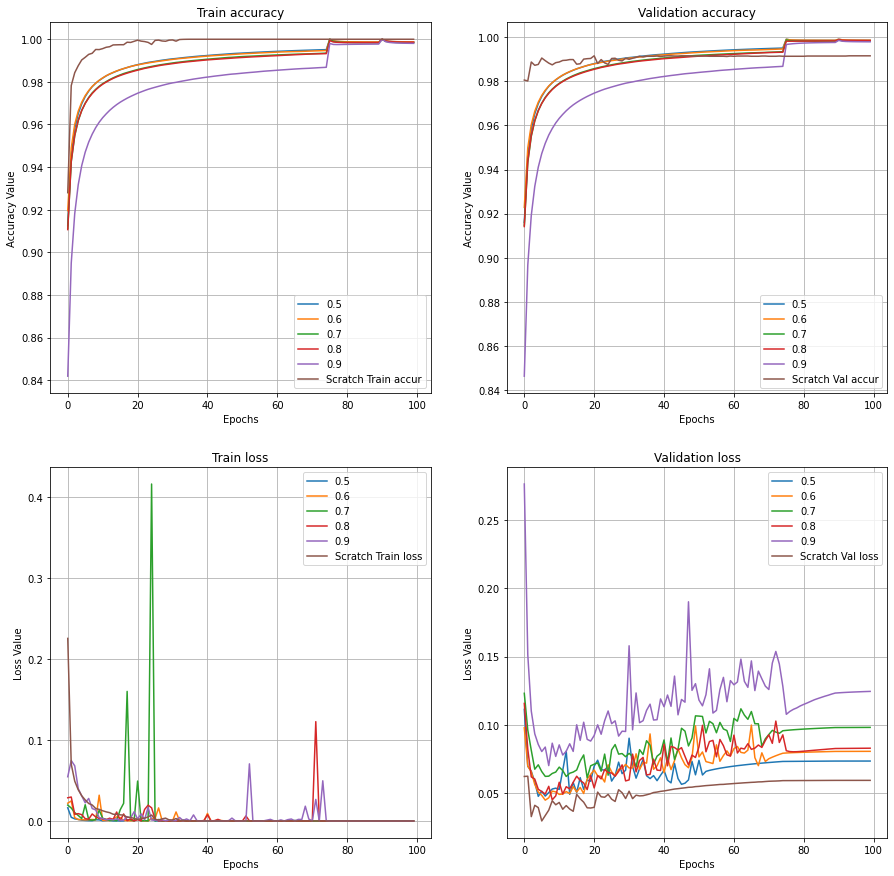

In [20]:
figname= f"test2_seed42.png"
eval_plot(dico, figname, scratch = True)

In [21]:
dico

{'scratch_hist': (array([0.92799997, 0.97825003, 0.98430002, 0.98756665, 0.99028331,
         0.99153334, 0.99290001, 0.99341667, 0.99519998, 0.99515003,
         0.99559999, 0.99623334, 0.99650002, 0.99733335, 0.99738336,
         0.9974333 , 0.9974333 , 0.99860001, 0.99849999, 0.99903333,
         0.99956667, 0.99911666, 0.99891669, 0.99853331, 0.99756664,
         0.99945003, 0.99959999, 0.99918336, 0.99905002, 0.99956667,
         0.99966669, 0.99910003, 0.99986666, 0.99994999, 0.99998331,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.       

In [22]:
#Save data
np.save("summary_Lenet_mnist_padded.npy", dico)